In [ ]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#ANN libreries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers

#clusters libraries
from sklearn.cluster import KMeans

## 1. Data

In [2]:
# read the data
base = pd.read_csv("data_pyme.csv")
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40117 entries, 0 to 40116
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   admission_date         40117 non-null  int64  
 1   income_monthly_amount  40117 non-null  float64
 2   balance_amount         40117 non-null  float64
 3   montoOR                40117 non-null  float64
 4   cantiOR                40117 non-null  float64
 5   transaOR               40117 non-null  float64
 6   montoDE                40117 non-null  float64
 7   cantiDE                40117 non-null  float64
 8   transaDE               40117 non-null  float64
 9   clasifica              40117 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 3.1 MB


In [3]:
base["clasifica"].value_counts()

1    36986
0     3131
Name: clasifica, dtype: int64

In [4]:
clasifica1 = base.query("clasifica == 1")
clasifica0 = base.query("clasifica == 0")

In [5]:
np.random.seed(42)
remove_n = len(clasifica1) - len(clasifica0)

drop_indices = np.random.choice(clasifica1.index, remove_n, replace=False)
data_1 = clasifica1.drop(drop_indices)

In [6]:
frames = [clasifica0,data_1]

In [7]:
data_concat = pd.concat(frames)

In [8]:
data_concat["clasifica"].value_counts()

1    3131
0    3131
Name: clasifica, dtype: int64

In [9]:
data_concat_sin_salida = data_concat.drop(['clasifica'], axis=1)

In [10]:
#normalizacion
mean = data_concat_sin_salida.mean()
std = data_concat_sin_salida.std()

data_norm_sin_salida = (data_concat_sin_salida - mean) / std

In [11]:
data = data_norm_sin_salida

In [12]:
data["salida"] = data_concat["clasifica"]

# 2. Cluster

In [13]:
# X: matriz de orden nxm, n: muestras, m:variables
# kMax: número máximo de clusters
def graficarInercia(X, kLista):
    
    inerciaList = []
    
    # hallar los diferentes clusters
    for k in kLista:
        kmeans = KMeans(n_clusters = k, 
                        random_state = 0, 
                        init = "random",
                        n_init = 10,
                        verbose = 0).fit(X)

        inerciaList.append(kmeans.inertia_)

    return kLista, inerciaList

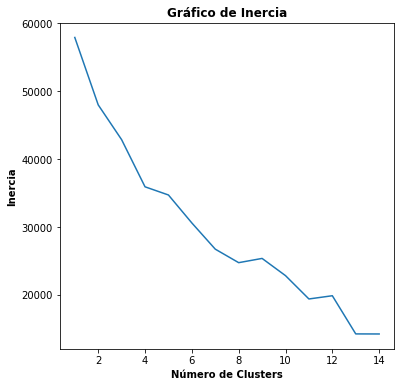

In [14]:
# gráfico de inercia para seleccionar el número adeuado de clusters
k_max = 15
x, y = graficarInercia(data, list(range(1, k_max)))

fig = plt.figure(figsize=(6,6))

plt.plot(x, y)
plt.title("Gráfico de Inercia", fontweight='bold')
plt.xlabel("Número de Clusters", fontweight='bold')
plt.ylabel("Inercia", fontweight='bold')
plt.xticks(list(range(2,k_max,2)))
plt.show()

In [15]:
# se escogió hallar 2 clusters
kmeans = KMeans(n_clusters = 2, 
                random_state = 42, 
                init = "random",
                n_init = 10,
                verbose = 0).fit(data)

### Capturar un registro al cluster

In [ ]:
#captura registro
#registro = [16,17218.00,3797.00,23568.00,11,8902,17879,6,3281]
#registro_numpy = np.array(registro).reshape(1, -1)
#salCluster = 1

#norma
#mean_reg = registro_numpy.mean()
#std_reg = registro_numpy.std()
#registro_numpy_norma = (registro_numpy - mean_reg) / std_reg
#registro_numpy_norma = np.append(registro_numpy_norma,salCluster).reshape(1, -1)

#insertar al cluster
#clustersWEB = kmeans.predict(registro_numpy_norma)

In [ ]:
#NOMBRE DEL CLUSTER! --> cluster 0
#clustersWEB

In [16]:
# almacenar los clusteres hallados
k_means_clusters = kmeans.predict(data)

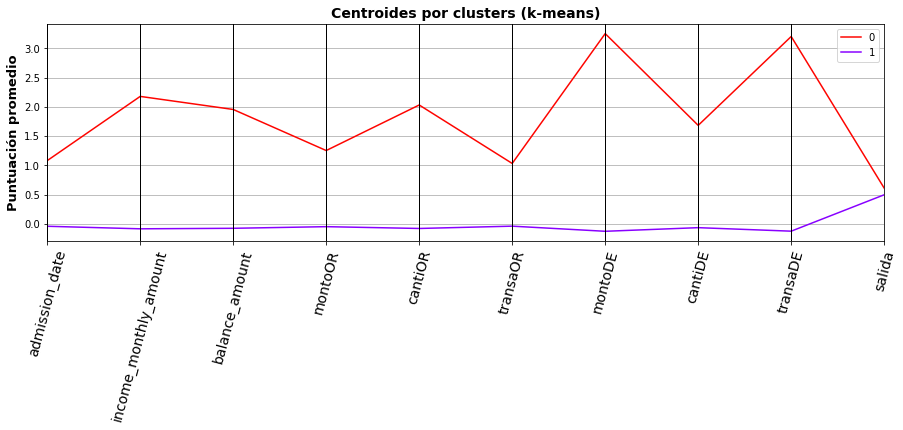

In [17]:
#graficar clusters

temp_df = pd.DataFrame(kmeans.cluster_centers_, columns=data.columns)
temp_df["k_means"] = kmeans.predict(temp_df.values)  # rename clusters names


fig = plt.figure(figsize=(15,4))

chart = pd.plotting.parallel_coordinates(
   frame = temp_df,
   class_column = "k_means",
   color = ('#fe0400', '#8800FF', '#1bb02a', '#ff00ff'))

chart.set_title("Centroides por clusters (k-means)", fontsize=14, fontweight='bold')
chart.set_ylabel("Puntuación promedio",fontsize=13, fontweight='bold')
chart.set_xticklabels(chart.get_xticklabels(), rotation=75, fontsize=14);

In [18]:
import collections, numpy

#cantidad de datos en cada cluster
collections.Counter(k_means_clusters)

Counter({1: 6024, 0: 238})

- Cluster 0: todo bajo (mas empresas)
- cluster 1: Todo alto (menos empresas)


# Redes Neuronales

## 1. Data

In [19]:
#convirtiendo a numpy data
data_numpy = data.values

In [20]:
clusterID = k_means_clusters

data_numpy_cluster = data_numpy

data_numpy_cluster = np.insert(data_numpy_cluster, len(data_numpy_cluster[0]+1), clusterID, axis=1)

In [21]:
def extraigoCluster(a):
    
    cluster0 = []

    #recorro todo el data set
    for i in range(len(data_numpy_cluster)):
    
        #condicion para solo tomar labels 0 o 1
        if(data_numpy_cluster[i,-1] == a):
            cluster0.append(data_numpy_cluster[i])

    return np.array(cluster0)

In [22]:
#agregando columnda de label de cluster y separando cada cluster en una variables
cluster0_np = extraigoCluster(0)
cluster1_np = extraigoCluster(1)

In [23]:
cluster0_np_total = np.delete(cluster0_np, -1, axis=1)
cluster1_np_total = np.delete(cluster1_np, -1, axis=1)

In [24]:
cluster0_np_total[0]

array([ 2.82197082, -0.24912428, 10.43706771,  1.47325999, 12.48306855,
        1.04948978,  5.10416598, 12.59220971,  3.89964151,  0.        ])

# 3. Redes Neuronales

### 3.1. Cluster 0

In [25]:
#Preparing inputs y outputs

ind_variables = len(cluster0_np_total[0])-1

In [26]:
#data y labels

X = cluster0_np_total[:, :ind_variables]
Y = cluster0_np_total[:, -1]

In [28]:
#train-test split  80% train / 20%testear

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## 2. Arquitectura

In [29]:
#infraestructuta de red

model_1 = Sequential([
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='relu'),
])


# configuracion de red

model_1.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'mae',
    metrics = ['accuracy'])

In [30]:
history = model_1.fit(x = X_train, 
                    y = y_train, 
                    validation_data = (X_test, y_test),
                    epochs=50
                    )

Epoch 1/50
6/6 [==============================] - 0s 24ms/step - loss: 0.9940 - accuracy: 0.5263 - val_loss: 1.1564 - val_accuracy: 0.6458
Epoch 2/50
6/6 [==============================] - 0s 3ms/step - loss: 0.8624 - accuracy: 0.5421 - val_loss: 1.0272 - val_accuracy: 0.6250
Epoch 3/50
6/6 [==============================] - 0s 4ms/step - loss: 0.7749 - accuracy: 0.5579 - val_loss: 0.9657 - val_accuracy: 0.6458
Epoch 4/50
6/6 [==============================] - 0s 4ms/step - loss: 0.7322 - accuracy: 0.5947 - val_loss: 0.9372 - val_accuracy: 0.6667
Epoch 5/50
6/6 [==============================] - 0s 4ms/step - loss: 0.7018 - accuracy: 0.5842 - val_loss: 0.9064 - val_accuracy: 0.6458
Epoch 6/50
6/6 [==============================] - 0s 4ms/step - loss: 0.6755 - accuracy: 0.5684 - val_loss: 0.8743 - val_accuracy: 0.6458
Epoch 7/50
6/6 [==============================] - 0s 5ms/step - loss: 0.6500 - accuracy: 0.5789 - val_loss: 0.8436 - val_accuracy: 0.6458
Epoch 8/50
6/6 [=================

In [31]:
# metrics
print("final metrics:", model_1.evaluate(X_test, y_test, verbose=False))


final metrics: [0.23663823306560516, 0.8958333134651184]


## agregar un nuevo registro

In [ ]:
#X_test.shape

In [ ]:
#registro_numpy_norma.shape

In [ ]:
#Xnew = registro_numpy_norma
#ynew = model_1.predict_classes(Xnew)

### 3.2 Cluster 1

In [32]:
#Preparing inputs y outputs

ind_variables1 = len(cluster1_np_total[0])-1

In [33]:
#data y labels

X1 = cluster1_np_total[:, :ind_variables1]
Y1 = cluster1_np_total[:, -1]

In [34]:
#train-test split  80% train / 20%testear

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)

In [38]:
#infraestructuta de red

model_2 = Sequential([
    Dense(10, activation='relu'),
    Dense(7, activation='relu'),
    Dense(1, activation='relu'),
])


# configuracion de red

model_2.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'mae',
    metrics = ['accuracy'])

In [39]:
history = model_2.fit(x = X1_train, 
                    y = y1_train, 
                    validation_data = (X1_test, y1_test),
                    epochs=50
                    )

Epoch 1/50
151/151 [==============================] - 0s 1ms/step - loss: 0.4849 - accuracy: 0.5113 - val_loss: 0.4604 - val_accuracy: 0.5502
Epoch 2/50
151/151 [==============================] - 0s 883us/step - loss: 0.4626 - accuracy: 0.5443 - val_loss: 0.4511 - val_accuracy: 0.5610
Epoch 3/50
151/151 [==============================] - 0s 872us/step - loss: 0.4552 - accuracy: 0.5580 - val_loss: 0.4459 - val_accuracy: 0.5693
Epoch 4/50
151/151 [==============================] - 0s 952us/step - loss: 0.4494 - accuracy: 0.5667 - val_loss: 0.4417 - val_accuracy: 0.5668
Epoch 5/50
151/151 [==============================] - 0s 854us/step - loss: 0.4443 - accuracy: 0.5700 - val_loss: 0.4379 - val_accuracy: 0.5751
Epoch 6/50
151/151 [==============================] - 0s 923us/step - loss: 0.4391 - accuracy: 0.5777 - val_loss: 0.4349 - val_accuracy: 0.5668
Epoch 7/50
151/151 [==============================] - 0s 998us/step - loss: 0.4343 - accuracy: 0.5833 - val_loss: 0.4347 - val_accuracy: 0

In [40]:
# metrics
print("final metrics:", model_2.evaluate(X1_test, y1_test, verbose=False))

final metrics: [0.4053576588630676, 0.6215767860412598]


In [ ]:
X1_test[0]

In [ ]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)